In [1]:
%load_ext autoreload
%autoreload 2

# Create MEIs with a pretrained model

In [2]:
import matplotlib.pyplot as plt
import math

import datajoint as dj
dj.config['database.host'] = 'at-database.ad.bcm.edu:3306'

dj.conn()

#define the external storage
dj.config['stores'] = {
  'minio': dict( # 'raw' storage for this pipeline
                protocol='file',
                location='/mnt/dj-stor01/users/maria/mouse_neuropixels_meis') #'cifs://at-storage5.ad.bcm.edu/dj-stor01/users/maria/''
}

dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = 'mouse_neuropixels_meis'
dj.config['mei.schema_name'] = 'mouse_neuropixels_meis'

Please enter DataJoint username:  mdiamantaki
Please enter DataJoint password:  ·············


Connecting mdiamantaki@at-database.ad.bcm.edu:3306


In [3]:
from sensorium.schemas import schema, Fabrikant, Dataset, Model, Trainer, Seed, TrainedModel, MEISeed, MEIMethod, MEISelector, TrainedEnsembleModel, MEI
from sensorium.schemas.scores import CorrelationToAverage, ValidationCorrelationToSingle

#### Seed table

In [49]:
# you can manually add as many seeds as you want! uncomment below..
# Seed().insert1({'seed': 1500})

In [ ]:
Seed()

#### Fabrikant table

In [5]:
# you can choose name, email, and affiliation as you like. I'd recommend setting the "name" to the datajoint username.
# insert_dict = {'name': 'maria', 
#                'email': 'mar.diamantaki@gmail.com', 
#                'affiliation': 'atlab'}
# Fabrikant().add_entry(**insert_dict)

In [6]:
Fabrikant()

fabrikant_name Name of the contributor that added this entry,full_name full name of the person,email e-mail address,affiliation conributor's affiliation (e.g. Sinz Lab),dj_username DataJoint username
maria,,mar.diamantaki@gmail.com,atlab,mdiamantaki


#### Dataset Table

In [11]:
#filenames = ['/notebooks/data/102_110_1_2.zip', '/notebooks/data/102_117_1_2.zip', '/notebooks/data/107_124_1_2.zip', '/notebooks/data/128_22_1_2.zip']
filenames = ['/notebooks/data/102_116_1_2.zip',] # '/notebooks/data/102_117_1_3.zip', '/notebooks/data/107_124_1_3.zip', '/notebooks/data/128_22_1_3.zip']


dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 64,
                 'exclude': None,
                 'file_tree': True,
                 'scale': 0.25,
                 'add_behavior_as_channels':False,
                 }
Dataset().add_entry(dataset_fn, dataset_config, dataset_fabrikant = "maria", dataset_comment="MD_102_116_allu_goodvar")

{'dataset_fn': 'sensorium.datasets.static_loaders',
 'dataset_hash': '2c111ac18fa164e37404e950abb82dc7'}

In [12]:
Dataset()


dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,dataset_config dataset configuration object,dataset_fabrikant Name of the contributor that added this entry,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,=BLOB=,maria,MD_102_116_allu_goodvar,2022-11-17 09:49:42
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,=BLOB=,maria,MD_4ses_an102_107_128_sua_goodvar,2022-11-16 13:35:46
sensorium.datasets.static_loaders,9a1966a89f21d5671d067db5e33dfe29,=BLOB=,maria,MD_4ses_an102_107_128_allu_goodvar,2022-11-17 00:41:49
sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,=BLOB=,maria,MD_102_116_sua_goodvar,2022-11-16 14:20:14


In [10]:
#(Dataset() & 'dataset_hash = "2c111ac18fa164e37404e950abb82dc7"').delete()

About to delete:
`mouse_neuropixels_meis`.`dataset`: 1 items


Proceed? [yes, No]:  yes


Committed.


#### Model table

In [10]:
# this is the original core
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'stack': -1,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_dilation': 1,
  'hidden_kern': 7,
  'hidden_channels': 64,
  'depth_separable': True,
  #'grid_mean_predictor': {'type': 'cortex',
  # 'input_dimensions': 2,
  # 'hidden_layers': 1,
  # 'hidden_features': 30,
  # 'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,}

In [12]:
#model_fabrikant doesn't have a default value
Model().add_entry(model_fn, model_config, model_fabrikant = "maria", model_comment="state of the art model")

{'model_fn': 'sensorium.models.stacked_core_full_gauss_readout',
 'model_hash': '7278b720cc903fb027668bb5530c202f'}

In [19]:
#this is the pretrained core
# restriction selects the model (that was tranined already), the dataset for which the model was trained, and the trainer hash
model_restriction = dict(model_hash="7278b720cc903fb027668bb5530c202f", dataset_hash = "9a1966a89f21d5671d067db5e33dfe29", trainer_hash = "328fbc5c2eecd0d5b0605ab037a70373", seed = 1000)

model_fn = 'sensorium.models.transfer_core_fullgauss_readout'
model_config = {
  'transfer_key':model_restriction, # it is some cells below.. fix it!
  'core_transfer_table':'TrainedModel',
  'gamma_readout': 0.0076,
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',}

In [20]:
#model_fabrikant doesn't have a default value
Model().add_entry(model_fn, model_config, model_fabrikant = "maria", model_comment="sota pretrained model for transfer of 4sessions from animals 102,107,128_all units")

{'model_fn': 'sensorium.models.transfer_core_fullgauss_readout',
 'model_hash': 'afd8b886620ebbe4ba3aa102ddfbc293'}

In [21]:
(Model()) # & 'model_hash = "7ede66b69429cc4eb295160ea40e1002"').delete()

model_fn name of the model function,model_hash hash of the model configuration,model_config model configuration to be passed into the function,model_fabrikant Name of the contributor that added this entry,model_comment short description,model_ts UTZ timestamp at time of insertion
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,=BLOB=,maria,state of the art model,2022-11-16 12:50:30
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,=BLOB=,maria,"sota pretrained model for transfer of 4sessions from animals 102,107,128_all units",2022-11-17 09:53:04
sensorium.models.transfer_core_fullgauss_readout,d2edad633ae70e5d164b443846c4f495,=BLOB=,maria,"sota pretrained model for transfer of 4sessions from animals 102,107,128",2022-11-16 14:22:03


In [18]:
#(Model & 'model_hash = "afd8b886620ebbe4ba3aa102ddfbc293"').delete()

About to delete:
`mouse_neuropixels_meis`.`model`: 1 items


Proceed? [yes, No]:  yes


Committed.


In [13]:
trainer_fn = "sensorium.training.standard_trainer"

trainer_config = {'max_iter': 200,
                 'verbose': False,
                 'lr_decay_steps': 4,
                 'avg_loss': False,
                 'lr_init': 0.009,
                 }

In [15]:
# MissingAttributeError: Field 'trainer_fabrikant' doesn't have a default value
Trainer().add_entry(trainer_fn, trainer_config, trainer_fabrikant = "maria", trainer_comment="default trainer 200 iter")

{'trainer_fn': 'sensorium.training.standard_trainer',
 'trainer_hash': '328fbc5c2eecd0d5b0605ab037a70373'}

In [8]:
(Trainer()  ) #& 'trainer_hash = "328fbc5c2eecd0d5b0605ab037a70373"').delete()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,trainer_config training configuration object,trainer_fabrikant Name of the contributor that added this entry,trainer_comment short description,trainer_ts UTZ timestamp at time of insertion
sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,=BLOB=,maria,default trainer 200 iter,2022-11-16 12:50:49


---

# Fill the TrainedModel table

In [124]:
# Now that Seed, Dataset, Model, and Trainer are filled, a model can be trained:

In [ ]:
ls

In [22]:
# to use the pretrained choose model_hash of the pretrained model and dataset_hash of the new dataset that you want to test
train_restriction = dict(model_hash="afd8b886620ebbe4ba3aa102ddfbc293", dataset_hash = "2c111ac18fa164e37404e950abb82dc7", trainer_hash = "328fbc5c2eecd0d5b0605ab037a70373")
train_restriction

{'model_hash': 'afd8b886620ebbe4ba3aa102ddfbc293',
 'dataset_hash': '2c111ac18fa164e37404e950abb82dc7',
 'trainer_hash': '328fbc5c2eecd0d5b0605ab037a70373'}

In [23]:
%%time
TrainedModel().populate(train_restriction, display_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")

Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]

Epoch 2: 100%|█████

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")

Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]

Epoch 2: 100%|█████

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")

Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.17it/s]

Epoch 2: 100%|█████

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")

Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.24it/s]

Epoch 2: 100%|█████

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")

Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  8.17it/s]

Epoch 2: 100%|█████

CPU times: user 32min 43s, sys: 19min 14s, total: 51min 57s
Wall time: 17min 7s


In [4]:
TrainedModel() 

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1000,default trainer 200 iter.state of the art model.MD_4ses_an102_107_128_sua_goodvar,0.252981,=BLOB=,maria,2022-11-16 13:58:32
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,9a1966a89f21d5671d067db5e33dfe29,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1000,default trainer 200 iter.state of the art model.MD_4ses_an102_107_128_allu_goodvar,0.266669,=BLOB=,maria,2022-11-17 01:25:12
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,10,default trainer 200 iter.state of the art model.MD_102_116_sua_goodvar,0.280461,=BLOB=,maria,2022-11-16 14:27:55
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,100,default trainer 200 iter.state of the art model.MD_102_116_sua_goodvar,0.286967,=BLOB=,maria,2022-11-16 14:32:19
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,500,default trainer 200 iter.state of the art model.MD_102_116_sua_goodvar,0.289646,=BLOB=,maria,2022-11-16 14:36:43
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1000,default trainer 200 iter.state of the art model.MD_102_116_sua_goodvar,0.282741,=BLOB=,maria,2022-11-16 14:40:20
sensorium.models.stacked_core_full_gauss_readout,7278b720cc903fb027668bb5530c202f,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1500,default trainer 200 iter.state of the art model.MD_102_116_sua_goodvar,0.285708,=BLOB=,maria,2022-11-16 14:43:43
sensorium.models.transfer_core_fullgauss_readout,d2edad633ae70e5d164b443846c4f495,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,10,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128.MD_102_116_sua_goodvar",0.275961,=BLOB=,maria,2022-11-16 23:49:35
sensorium.models.transfer_core_fullgauss_readout,d2edad633ae70e5d164b443846c4f495,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,100,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128.MD_102_116_sua_goodvar",0.268253,=BLOB=,maria,2022-11-16 23:52:32
sensorium.models.transfer_core_fullgauss_readout,d2edad633ae70e5d164b443846c4f495,sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,500,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128.MD_102_116_sua_goodvar",

In [24]:
TrainedModel() & train_restriction

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,10,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.333794,=BLOB=,maria,2022-11-17 09:57:49
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,100,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.329885,=BLOB=,maria,2022-11-17 10:01:14
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,500,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.323787,=BLOB=,maria,2022-11-17 10:05:01
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1000,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.329764,=BLOB=,maria,2022-11-17 10:07:51
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1500,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.331038,=BLOB=,maria,2022-11-17 10:11:23


In [32]:
CorrelationToAverage().populate(train_restriction)

OrderedDict([('train', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe4a8329100>)])), ('validation', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bd3a7220>)])), ('test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bd3a7880>)])), ('final_test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bd3a7b20>)]))])


/usr/local/lib/python3.8/dist-packages/nnfabrik/templates/trained_model.py:203: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


OrderedDict([('train', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bd3a7370>)])), ('validation', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc25cb20>)])), ('test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc25cd90>)])), ('final_test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc25c2e0>)]))])


/usr/local/lib/python3.8/dist-packages/nnfabrik/templates/trained_model.py:203: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


OrderedDict([('train', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a648310>)])), ('validation', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a640760>)])), ('test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a76da60>)])), ('final_test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc0fb4c0>)]))])


/usr/local/lib/python3.8/dist-packages/nnfabrik/templates/trained_model.py:203: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


OrderedDict([('train', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a6afeb0>)])), ('validation', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3be857a00>)])), ('test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3be8573d0>)])), ('final_test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc2c5190>)]))])


/usr/local/lib/python3.8/dist-packages/nnfabrik/templates/trained_model.py:203: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


OrderedDict([('train', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe3bc2c5880>)])), ('validation', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a7d0b80>)])), ('test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a7d02e0>)])), ('final_test', OrderedDict([('102-116-1', <torch.utils.data.dataloader.DataLoader object at 0x7fe47a7d0af0>)]))])


/usr/local/lib/python3.8/dist-packages/nnfabrik/templates/trained_model.py:203: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [8]:
restriction

{'model_hash': '7278b720cc903fb027668bb5530c202f',
 'dataset_hash': '4276e2103b42f48d63018634cdbfb0fc',
 'trainer_hash': '328fbc5c2eecd0d5b0605ab037a70373',
 'seed': 1000}

In [26]:
from sensorium.utility.scores import get_signal_correlations

In [10]:
cd '/home/maria/github/sensorium'

/home/maria/github/sensorium


In [23]:
# how to load trained model from the table. It only works if the table is restricted to one entry
dataloaders, model = (TrainedModel() & train_restriction & 'seed=1000').load_model()

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [24]:
model.cuda().eval();

In [27]:
cor = get_signal_correlations(model, dataloaders, tier='test', device="cuda", as_dict=False, per_neuron=True)

In [28]:
cor

array([0.4719845 , 0.42925704, 0.11915782, 0.31211507, 0.31683293,
       0.38327208, 0.53620315, 0.48084298, 0.3162373 , 0.34065515,
       0.6137165 , 0.35372117, 0.17745915, 0.24583843, 0.5801455 ,
       0.78961146, 0.39879364, 0.6959007 , 0.69752836, 0.7927587 ,
       0.49459073, 0.7342614 , 0.8297812 , 0.25636023, 0.24392933,
       0.61188453, 0.18061152, 0.32785115, 0.4452565 , 0.81610924,
       0.49907532, 0.21631414, 0.10244625, 0.2785123 , 0.3703801 ,
       0.3772372 , 0.48628142], dtype=float32)

In [29]:
cor.mean()

0.4411599

In [18]:
# this is the model with all of the trained parameters
print(model)

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, 

---

# How to create an MEI

## Fill MEISeed

In [19]:
MEISeed()

mei_seed MEI seed
1000


In [62]:
MEISeed().insert1({'mei_seed': 1000})

In [25]:
MEISeed()

mei_seed MEI seed
1000


## Fill MEISelector

In [26]:
# the MEI selector is the table that selects the target for the MEI, in our case, it is a single neuron. 
MEISelector() 

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,unit_id unique neuron identifier,data_key unique session identifier,unit_index integer position of the neuron in the model's output
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,220,107-124-1,0
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,234,107-124-1,1
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,243,107-124-1,2
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,244,107-124-1,3
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,245,107-124-1,4
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,255,107-124-1,5
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,258,107-124-1,6
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,264,107-124-1,7
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,276,107-124-1,8
sensorium.datasets.static_loaders,6bf49110998881f8838fa98b47fab1a4,277,107-124-1,9


In [27]:
MEISelector().populate(display_progress=True)

100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


In [36]:
import numpy as np
np.unique(MEISelector().fetch('data_key'))

array(['102-110-1', '102-116-1', '102-117-1', '107-124-1', '128-22-1',
       '27152-28-1', '27152-31-1'], dtype=object)

In [21]:
# it is now filled with 1 row per neuron present in the dataset
MEISelector() & 'data_key = "107-124-1"'

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,unit_id unique neuron identifier,data_key unique session identifier,unit_index integer position of the neuron in the model's output
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,210,107-124-1,0
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,211,107-124-1,1
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,212,107-124-1,2
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,213,107-124-1,3
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,215,107-124-1,4
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,218,107-124-1,5
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,219,107-124-1,6
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,220,107-124-1,7
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,224,107-124-1,8
sensorium.datasets.static_loaders,690d9ad6116abb989106f7e98a4e4fee,225,107-124-1,9


# Filling the Ensemble Table

In [29]:
# MEIs are per default generated from a model ensemble. Usually we train 5 seeds of the same model, 
# and select these 5 models and add the keys of them to the ensemble table to form an ensemble
# here, for simplicity, I'm selecting the only trainedmodel we have

#trainedmodel_keys = TrainedModel().fetch("KEY")

trainedmodel_keys = (TrainedModel() & train_restriction).fetch("KEY")

In [28]:
TrainedModel() & train_restriction

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,10,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.333794,=BLOB=,maria,2022-11-17 09:57:49
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,100,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.329885,=BLOB=,maria,2022-11-17 10:01:14
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,500,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.323787,=BLOB=,maria,2022-11-17 10:05:01
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1000,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.329764,=BLOB=,maria,2022-11-17 10:07:51
sensorium.models.transfer_core_fullgauss_readout,afd8b886620ebbe4ba3aa102ddfbc293,sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,sensorium.training.standard_trainer,328fbc5c2eecd0d5b0605ab037a70373,1500,"default trainer 200 iter.sota pretrained model for transfer of 4sessions from animals 102,107,128_all units.MD_102_116_allu_goodvar",0.331038,=BLOB=,maria,2022-11-17 10:11:23


In [36]:
trainedmodel_keys

[{'model_fn': 'sensorium.models.transfer_core_fullgauss_readout',
  'model_hash': 'd2edad633ae70e5d164b443846c4f495',
  'dataset_fn': 'sensorium.datasets.static_loaders',
  'dataset_hash': 'f6e1597f9a26509275661669ea3dcc9b',
  'trainer_fn': 'sensorium.training.standard_trainer',
  'trainer_hash': '328fbc5c2eecd0d5b0605ab037a70373',
  'seed': 10},
 {'model_fn': 'sensorium.models.transfer_core_fullgauss_readout',
  'model_hash': 'd2edad633ae70e5d164b443846c4f495',
  'dataset_fn': 'sensorium.datasets.static_loaders',
  'dataset_hash': 'f6e1597f9a26509275661669ea3dcc9b',
  'trainer_fn': 'sensorium.training.standard_trainer',
  'trainer_hash': '328fbc5c2eecd0d5b0605ab037a70373',
  'seed': 100},
 {'model_fn': 'sensorium.models.transfer_core_fullgauss_readout',
  'model_hash': 'd2edad633ae70e5d164b443846c4f495',
  'dataset_fn': 'sensorium.datasets.static_loaders',
  'dataset_hash': 'f6e1597f9a26509275661669ea3dcc9b',
  'trainer_fn': 'sensorium.training.standard_trainer',
  'trainer_hash': '32

In [169]:
#TrainedEnsembleModel().delete()

About to delete:
`md_neuropixels_meis`.`trained_ensemble_model__member`: 1 items
`md_neuropixels_meis`.`trained_ensemble_model`: 1 items


Proceed? [yes, No]:  yes


Committed.


In [30]:
# this adds our trainedmodels to the ensemble table
TrainedEnsembleModel().create_ensemble(trainedmodel_keys, comment="N=5 models")

In [31]:
TrainedEnsembleModel()

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,ensemble_comment a short comment describing the ensemble
sensorium.datasets.static_loaders,2c111ac18fa164e37404e950abb82dc7,fa8366912c31771a6594b3c9f7db88e4,N=5 models
sensorium.datasets.static_loaders,f6e1597f9a26509275661669ea3dcc9b,68da99441dfe2b4eb373827b9617f1e0,N=5 models


# Filling the Method Table

In [39]:
# this specifies all the optimization parameters
MEIMethod()

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method


In [40]:
method_fn = "mei.methods.gradient_ascent"


method_config = { 'initial': {'path': 'mei.initial.RandomNormal',},
                 'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 10}}, # learning rate
                 'precondition': {'path': 'mei.legacy.ops.GaussianBlur',         # gaussian blurring on the gradient, to avoid high frequency artefacts
                  'kwargs': {'sigma': 1}},
                 'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
                  'kwargs': {'norm': 10, }},                                     # Contrast constraint: Limits the L2 norm of the image to 10
                 'stopper': {'path': 'mei.stoppers.NumIterations',
                  'kwargs': {'num_iterations': 1000}},                           # Number of iterations
                 'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                   'kwargs': {'interval': 10}}],                                 # Saves the output activation every 10th step.
                 'device': 'cuda'}


MEIMethod().add_method(method_fn, method_config, comment="Default MEI Method", )

In [48]:
MEIMethod()

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,=BLOB=,2022-11-17 00:15:39,Default MEI Method


# Optimize an MEI

In [32]:
mei_restriction = dict(ensemble_hash = "fa8366912c31771a6594b3c9f7db88e4",
                      method_hash = "8c7de77acabedc9479aa207d8e914e9d",
                      dataset_hash = "2c111ac18fa164e37404e950abb82dc7",)

In [33]:
%%time
# computes MEIs for all units, methods, seeds, and ensemble models
MEI().populate(mei_restriction, display_progress=True)

  0%|          | 0/181 [00:00<?, ?it/s]

Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


Building model...


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")
100%|██████████| 181/181 [1:32:33<00:00, 30.68s/it]

CPU times: user 1h 32min 42s, sys: 36.1 s, total: 1h 33min 18s
Wall time: 1h 32min 33s


In [47]:
MEI() #& restriction

method_fn name of the method function,method_hash hash of the method config,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,unit_id unique neuron identifier,data_key unique session identifier,mei_seed MEI seed,mei the MEI as a tensor,score some score depending on the used method function,output object returned by the method function


In [67]:
import numpy as np

In [68]:
np.unique(MEI().fetch('data_key'))

array(['102-116-1'], dtype=object)

In [41]:
MEI() & 'data_key = "102-110-1"' #& 'data_key = "27152-15-1" OR data_key = "27152-17-1"' #& 'data_key != "27152-31-1"'

method_fn name of the method function,method_hash hash of the method config,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,unit_id unique neuron identifier,data_key unique session identifier,mei_seed MEI seed,mei the MEI as a tensor,score some score depending on the used method function,output object returned by the method function
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,534,102-110-1,1000,=BLOB=,1.00291,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,541,102-110-1,1000,=BLOB=,0.963177,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,542,102-110-1,1000,=BLOB=,1.6505,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,544,102-110-1,1000,=BLOB=,0.849482,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,545,102-110-1,1000,=BLOB=,0.914835,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,546,102-110-1,1000,=BLOB=,0.315895,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,547,102-110-1,1000,=BLOB=,2.77938,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,548,102-110-1,1000,=BLOB=,1.05596,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,549,102-110-1,1000,=BLOB=,0.458063,=BLOB=
mei.methods.gradient_ascent,8c7de77acabedc9479aa207d8e914e9d,sensorium.datasets.static_loaders,50acf7555b481ed768dcbc381c9edf30,1b28b1e932d6108704c661703408fca1,550,102-110-1,1000,=BLOB=,3.31715,=BLOB=


In [71]:
import torch

In [76]:
ls

Dockerfile*
Examples.ipynb
LICENSE
README.md
docker-compose.yml*
docker-compose.yml.jinja*
mei/
mei.egg-info/
mei_ASdsXBegKktGwKmBIhwAbCWrNmofboLP.pth.tar
mei_CFYjSBRPzSwJNufsETJTikJbdcgFOfPu.pth.tar
mei_CFtdsrgdletKiiqlcwQAtOMOspiwKgwv.pth.tar
mei_CNahyEoLAOEOrTZntMPShagsivWyUiOc.pth.tar
mei_ElvkIDNEVQOyvoLfduOemGzpbaERvBCt.pth.tar
mei_EohDpHhcXGgwdTbHWTNUhHvBaglfEaSL.pth.tar
mei_IFyyEDGzbYNGSvGkfsCWalDAREDyXuGJ.pth.tar
mei_InpSostaeumOPDpDzCBHWnqfTVWUkBoP.pth.tar
mei_LDmxTfWiMUUQzlSCXbGjCwrnlotSzTGD.pth.tar
mei_LZJeHyKZQGxvgahmcomPIeUYuFlFlwUn.pth.tar
mei_McJHAhvuSvaWePfGPsTTkOOcTKaGmatG.pth.tar
mei_MzHYJiItZpCWSXnXxYLdZVXdtdzTRuqh.pth.tar
mei_NtlfRTnNwBnJWvghkJYEgSvRDazeieEK.pth.tar
mei_PcYsTQreWjcirFCTVLSKMBivwRiBOynP.pth.tar
mei_QSsjYaDYSFfAUfCzcZRianWeHxZNKmtA.pth.tar
mei_RkbvHLZxNdsGekSwVmuwtTbDXjYQoTOf.pth.tar
mei_VgjKDegcDPIgNWickNvoTARPmrCNwROb.pth.tar
mei_WCwkfhtPYtJZsHpHxzzdVktaDfvrzJxT.pth.tar
mei_bKkGNsZxpitxMdlLApDFhOVyWQLwGCeZ.pth.tar
mei_bVbPduewImGBkjWEtZYrpzgLBnlCmBT

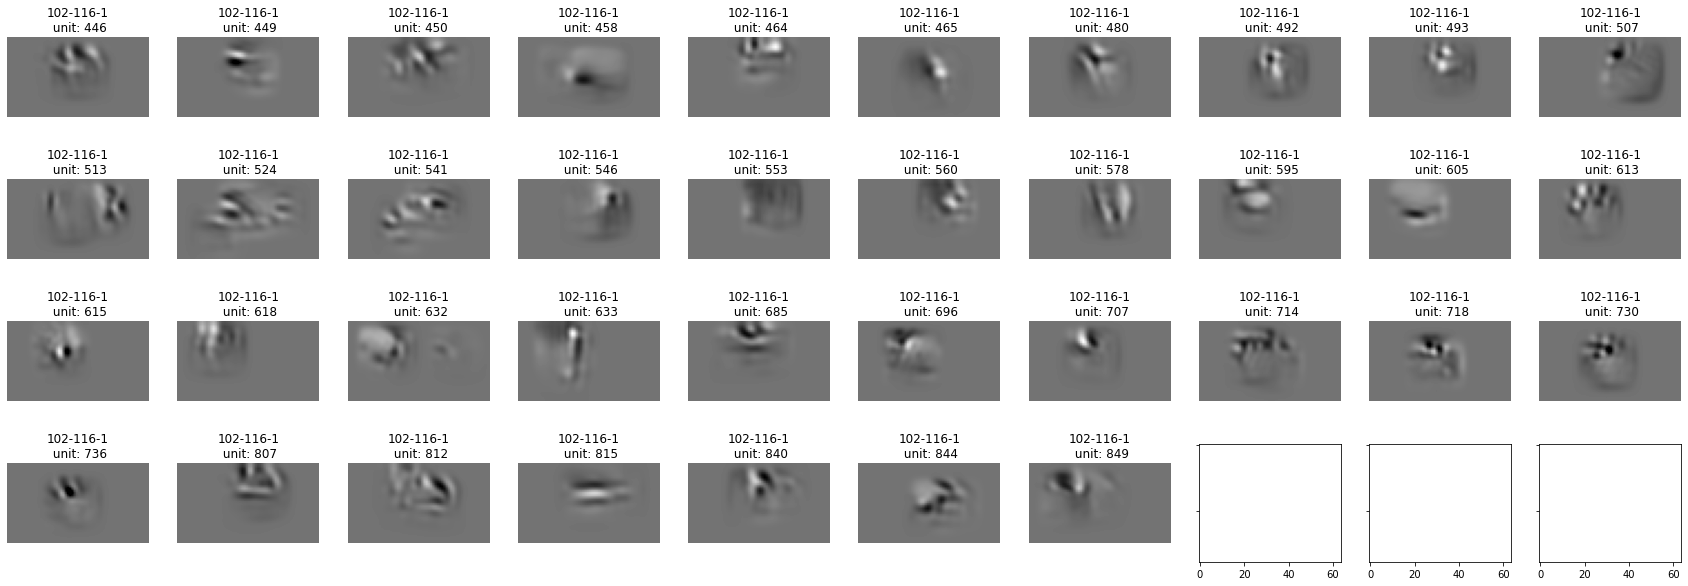

In [78]:
units, keys, mei_path = (MEI() & 'data_key = "102-116-1"').fetch("unit_id", "data_key", "mei", order_by=('data_key','unit_id'))

ncol = 10
nrow = math.ceil((len(keys)/ncol))


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(30, 10), gridspec_kw = {'wspace':0.2, 'hspace':0.2}) 
ax = ax.ravel()
i=0
for ipth in range(len(mei_path)):
    mei = torch.load(mei_path[ipth])
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    ax[i].imshow(mei_array, cmap="gray", vmin=-1.8, vmax=2.2)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axis("off") 
    ax[i].set_title(f'{keys[ipth]}\n unit: {units[ipth]}')
    #ax[i].set_title(f'{i}')
    i=i+1

fig.savefig('npx_meis_102_116_sua.pdf')
#fig.tight_layout()

In [45]:
mei_df = (MEI() & 'data_key = "102-110-1"').fetch(format="frame", order_by='unit_id asc')
mei_df

mei  \
method_fn                   method_hash                      dataset_fn                        dataset_hash                     ensemble_hash                    unit_id data_key  mei_seed                                                      
mei.methods.gradient_ascent 8c7de77acabedc9479aa207d8e914e9d sensorium.datasets.static_loaders 50acf7555b481ed768dcbc381c9edf30 1b28b1e932d6108704c661703408fca1 534     102-110-1 1000      mei_XBQWgzweDkIBioQpxRFmRQxoZDlcRVFj.pth_0006.tar   
                                                                                                                                                                 541     102-110-1 1000      mei_JhmsyuQoowNFhsyDxFMrEvadjCPTeosY.pth_0006.tar   
                                                                                                                                                                 542     102-110-1 1000      mei_TkgFANDyzHbtdcmmgvmjgeiJrnJvgUnO.pth_0006.tar   
                                                                                                                                                                 544     102-110-1 1000      mei_qHATXaPcDVMdRyeSErTOnbBgYsnvovoa.pth_0006.tar   
                                                                                                                                                                 545     102-110-1 1000      mei_FBNnljsVPBshWqiCOzkEoqqIewVIZHfW.pth_0006.tar   
...                                                                                                                                                                                                                                        ...   
                                                                                                                                                                 924     102-110-1 1000      mei_acIQHGvZZFgUIqfknPfWKgjENTvGFVsE.pth_0001.tar   
                                                                                                                                                                 925     102-110-1 1000      mei_KeDRHpWggyJkhsMGjIkUtqTjwWqpAmhJ.pth_0001.tar   
                                                                                                                                                                 928     102-110-1 1000      mei_SyqHhxNuxooalGZYPbxPoZbUdwaKDXEm.pth_0001.tar   
                                                                                                                                                                 929     102-110-1 1000      mei_KcJVmSrmLOGBCRoHOlBGQDptDQdhZYxn.pth_0001.tar   
                                                                                                                                                                 930     102-110-1 1000      mei_KVplxkDKYeOWcOGjtYNvyUbvAjRdcYJb.pth_0001.tar   

                                                                                                                                                                                                score  \
method_fn                   method_hash                      dataset_fn                        dataset_hash                     ensemble_hash                    unit_id data_key  mei_seed             
mei.methods.gradient_ascent 8c7de77acabedc9479aa207d8e914e9d sensorium.datasets.static_loaders 50acf7555b481ed768dcbc381c9edf30 1b28b1e932d6108704c661703408fca1 534     102-110-1 1000      1.002910   
                                                                                                                                                                 541     102-110-1 1000      0.963177   
                                                                                                                                                                 542     102-110-1 1000      1.650500   
                                                                                   

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

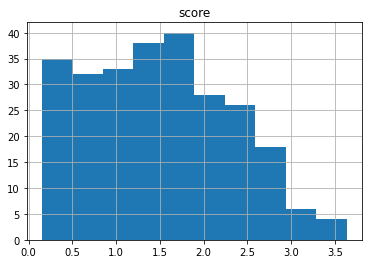

In [46]:
mei_df.hist()

In [43]:
npx = dj.create_virtual_module('neuropixels.py', 'lab_neuropixels')

In [47]:
key = {'animal_id' : 102,
       'session' : 110}

In [51]:
npx.UnitArea() & key & 'unit_id = 634'

animal_id,session,rec_idx,sort_idx,unit_id,area
102,110,1,1,634,LVA


In [56]:
area[0]

'LVA'

In [69]:
key = {'animal_id' : 102,
       'session' : 116}

units, mei_path = (MEI() & 'data_key = "102-116-1"').fetch("unit_id", "mei", order_by=('unit_id asc'))
max_depth = np.max((npx.ClusterInfo & key).fetch('depth'))

data_list = []

for ipth, path in enumerate(mei_path):
    mei = torch.load(path)
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    area = (npx.UnitArea() & key & f'unit_id = {units[ipth]}').fetch('area')[0]
    unit_depth = max_depth - (npx.ClusterInfo & key & f'unit_id = {units[ipth]}').fetch('depth')[0] 
    
    data_list.append([key['animal_id'], key['session'], units[ipth], area, unit_depth, mei_array])

    
   

NameError: name 'npx' is not defined

In [71]:
import pandas as pd

In [72]:
data_df = pd.DataFrame(data_list, columns=['animal_id', 'session', 'unit_id', 'area', 'depth', 'mei'])
data_df

,animal_id,session,unit_id,area,depth,mei
0,102,110,534,LVA,2060.0,"[[-6.077079e-09, 1.606425e-09, -2.2792208e-09,..."
1,102,110,541,LVA,2040.0,"[[-1.2833473e-09, 3.392421e-10, -6.959009e-10,..."
2,102,110,542,LVA,2060.0,"[[-6.2818515e-19, 1.660559e-19, -2.356022e-19,..."
3,102,110,544,LVA,2020.0,"[[-7.145723e-11, 1.8889144e-11, -2.680013e-11,..."
4,102,110,545,LVA,2060.0,"[[-6.3340854e-16, 1.6743635e-16, -2.3756077e-1..."
5,102,110,546,LVA,2040.0,"[[-0.0030531413, 0.00080707314, -0.0011450843,..."
6,102,110,547,LVA,2040.0,"[[-2.230307e-23, 5.8956384e-24, -8.364793e-24,..."
7,102,110,548,LVA,2000.0,"[[-6.87504e-10, 1.8173617e-10, -2.5784952e-10,..."
8,102,110,549,LVA,2000.0,"[[-7.340569e-13, 1.9404178e-13, -2.7530924e-13..."
9,102,110,550,LVA,2000.0,"[[-9.747667e-11, 2.576718e-11, -3.6558784e-11,..."


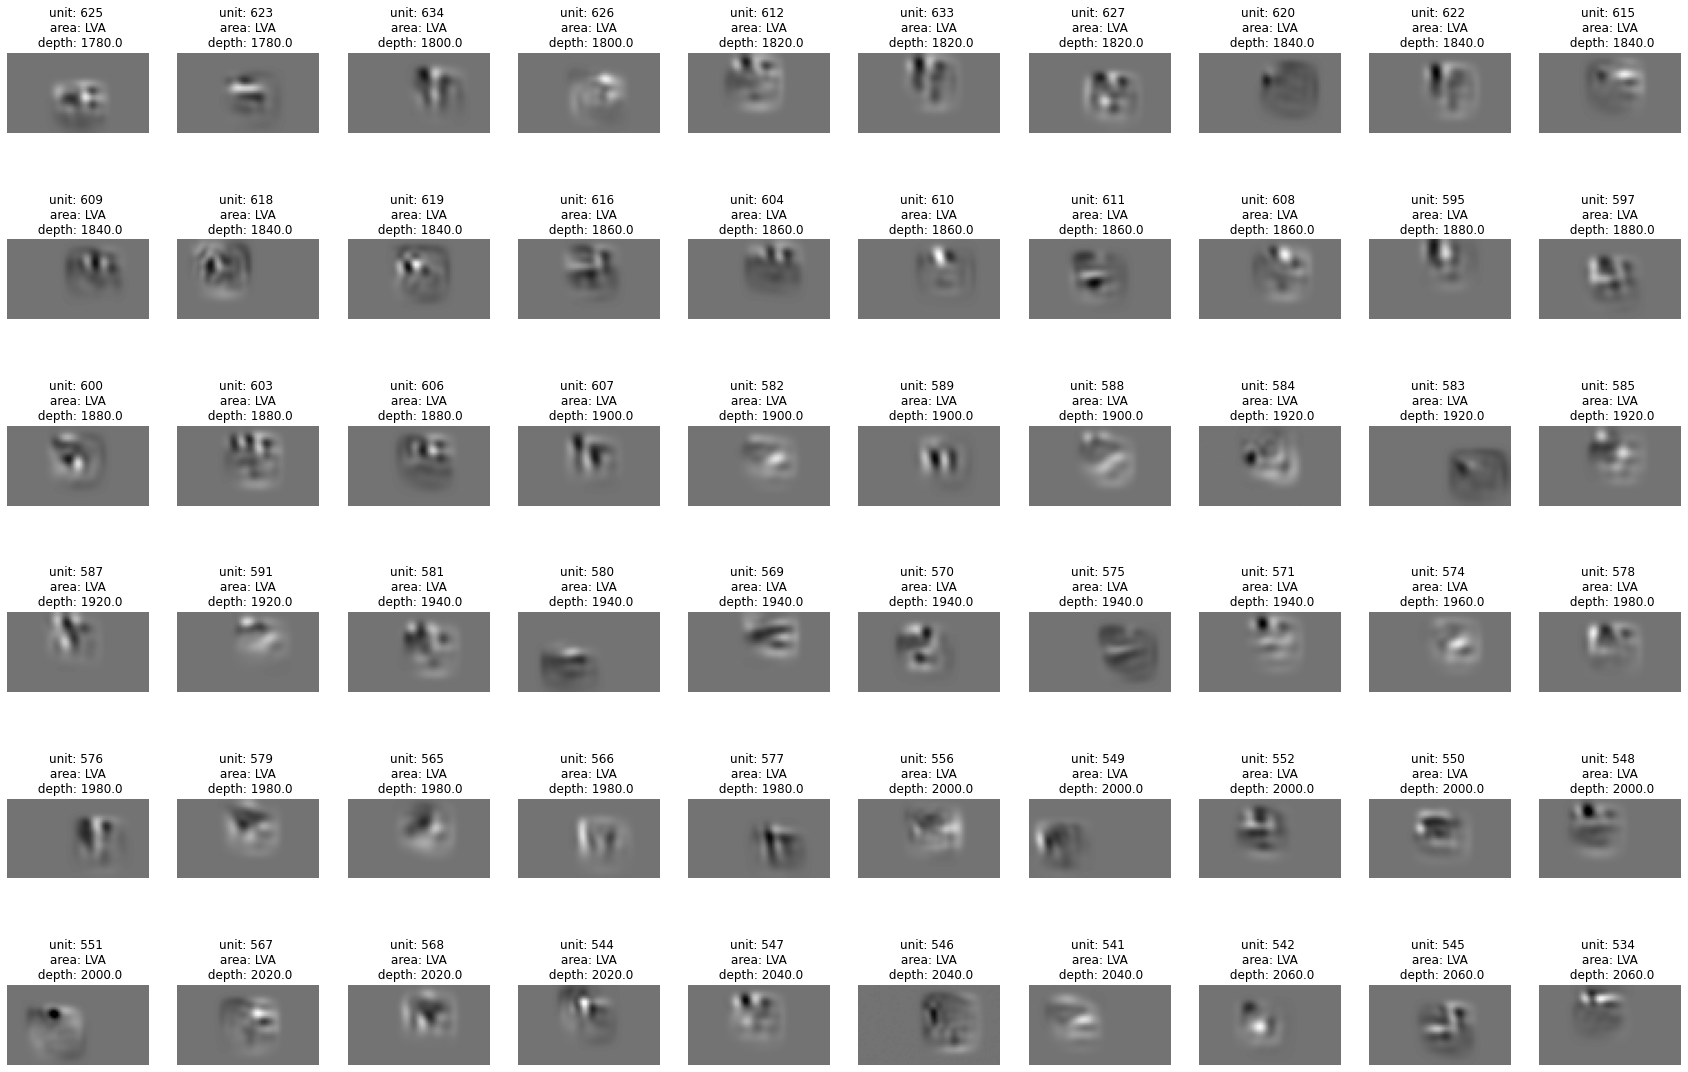

In [93]:
data_df = data_df.sort_values(by=['depth'])
data_df = data_df.reset_index(drop=True)

ncol = 10
nrow = math.ceil((len(data_df)/ncol))


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(30, 20), gridspec_kw = {'wspace':0.2, 'hspace':0.2}) 
ax = ax.ravel()
i=0
for ipth in range(len(data_df)):
    
    ax[i].imshow(data_df['mei'][ipth], cmap="gray", vmin=-1.8, vmax=2.2)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axis("off") 
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    ax[i].set_title(f'unit: {data_df["unit_id"][ipth]} \n area: {data_df["area"][ipth]} \n depth: {data_df["depth"][ipth]}')
    i=i+1

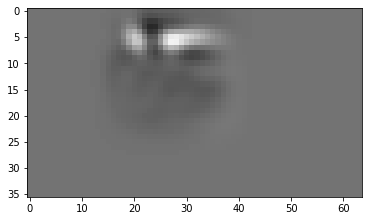

In [77]:
plt.imshow(data_df['mei'][0], cmap="gray", vmin=-1.8, vmax=2.2)

In [29]:
300/16

18.75

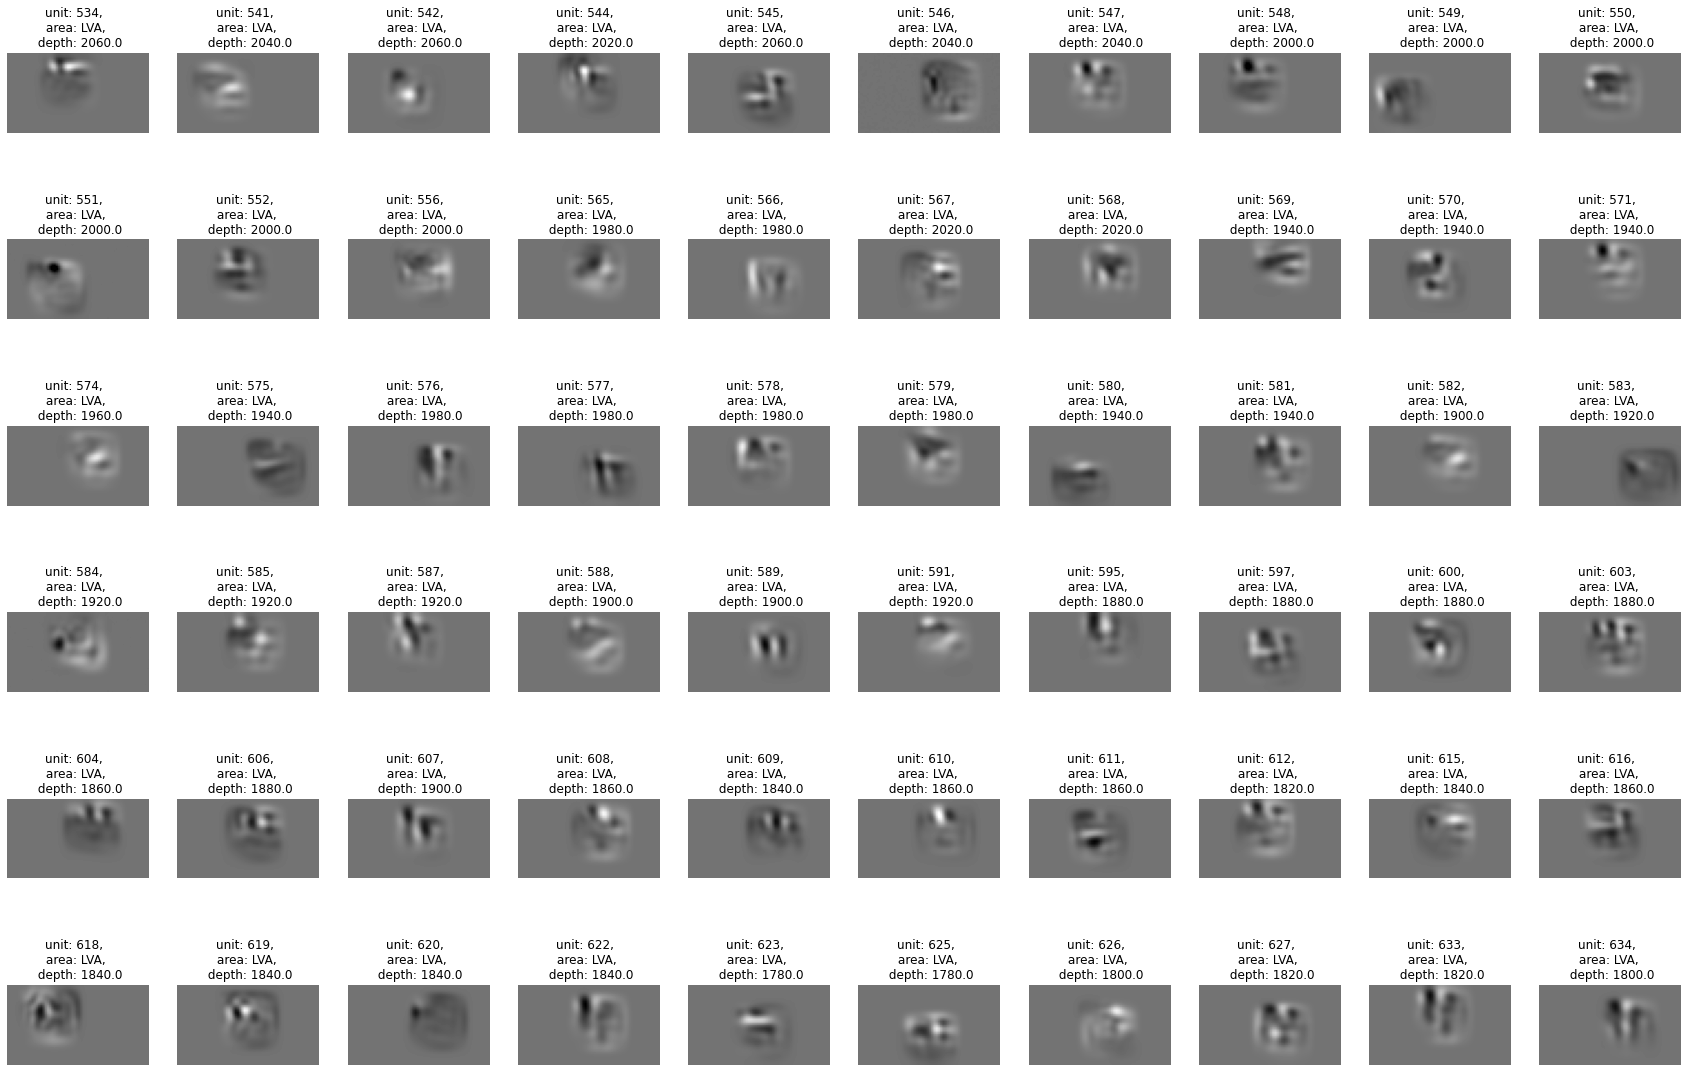

In [66]:
key = {'animal_id' : 102,
       'session' : 110}

units, mei_path = (MEI() & 'data_key = "102-110-1"' & 'unit_id <=634').fetch("unit_id", "mei", order_by=('unit_id asc'))
max_depth = np.max((npx.ClusterInfo & key).fetch('depth'))

ncol = 10
nrow = math.ceil((len(units)/ncol))


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(30, 20), gridspec_kw = {'wspace':0.2, 'hspace':0.2}) 
ax = ax.ravel()
i=0
for ipth, path in enumerate(mei_path):
    mei = torch.load(path)
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    area = (npx.UnitArea() & key & f'unit_id = {units[ipth]}').fetch('area')[0]
    unit_depth = max_depth - (npx.ClusterInfo & key & f'unit_id = {units[ipth]}').fetch('depth')[0] 
    
    ax[i].imshow(mei_array, cmap="gray", vmin=-1.8, vmax=2.2)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axis("off") 
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    ax[i].set_title(f'unit: {units[ipth]} \n area: {area} \n depth: {unit_depth}')
    i=i+1

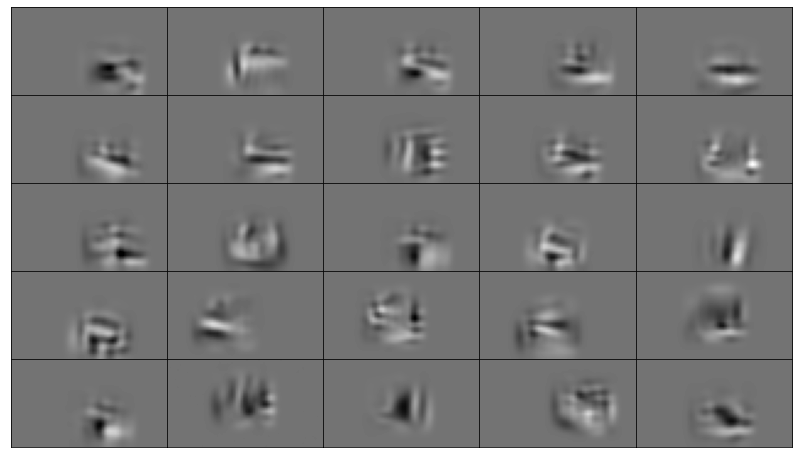

In [215]:
units, keys, mei_path = (MEI() & 'data_key = "27152-28-1" OR data_key = "27152-31-1"').fetch("unit_id", "data_key", "mei", order_by=('data_key','unit_id'))

x = [0, 2, 3, 4, 6, 7, 8, 14, 15, 17, 20, 23, 29, 34, 36, 46, 47, 49, 54, 55, 62, 82, 87, 103, 215 ]

ncol = 5
nrow = 5


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(14, 8.1), gridspec_kw = {'wspace':0.0, 'hspace':0.0}) 
ax = ax.ravel()
i=0
for ipth in x:
    mei = torch.load(mei_path[ipth])
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    ax[i].imshow(mei_array, cmap="gray", vmin=-1.8, vmax=2.2)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    #ax[i].axis("off") 
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    i=i+1

fig.savefig('selection_npx_meis_25.pdf')
#fig.tight_layout()

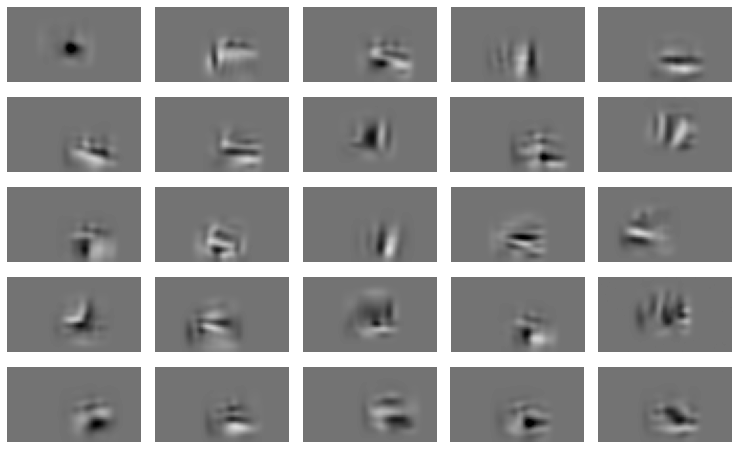

In [233]:
units, keys, mei_path = (MEI() & 'data_key = "27152-28-1" OR data_key = "27152-31-1"').fetch("unit_id", "data_key", "mei", order_by=('data_key','unit_id'))

x = [86, 2, 3, 38, 6, 7, 8, 92, 20, 27, 29, 34, 36, 59, 47, 172, 54, 55, 62, 82, 120, 194, 209, 213, 215 ]

ncol = 5
nrow = 5


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(13, 8), gridspec_kw = {'wspace':0.1, 'hspace':0.2}) 
ax = ax.ravel()
i=0
for ipth in x:
    mei = torch.load(mei_path[ipth])
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    ax[i].imshow(mei_array, cmap="gray", vmin=-1.8, vmax=2.2)
    #ax[i].axes.xaxis.set_visible(False)
    #ax[i].axes.yaxis.set_visible(False)
    ax[i].axis("off") 
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    i=i+1

fig.savefig('selection_npx_meis_25_2.pdf')
#fig.tight_layout()

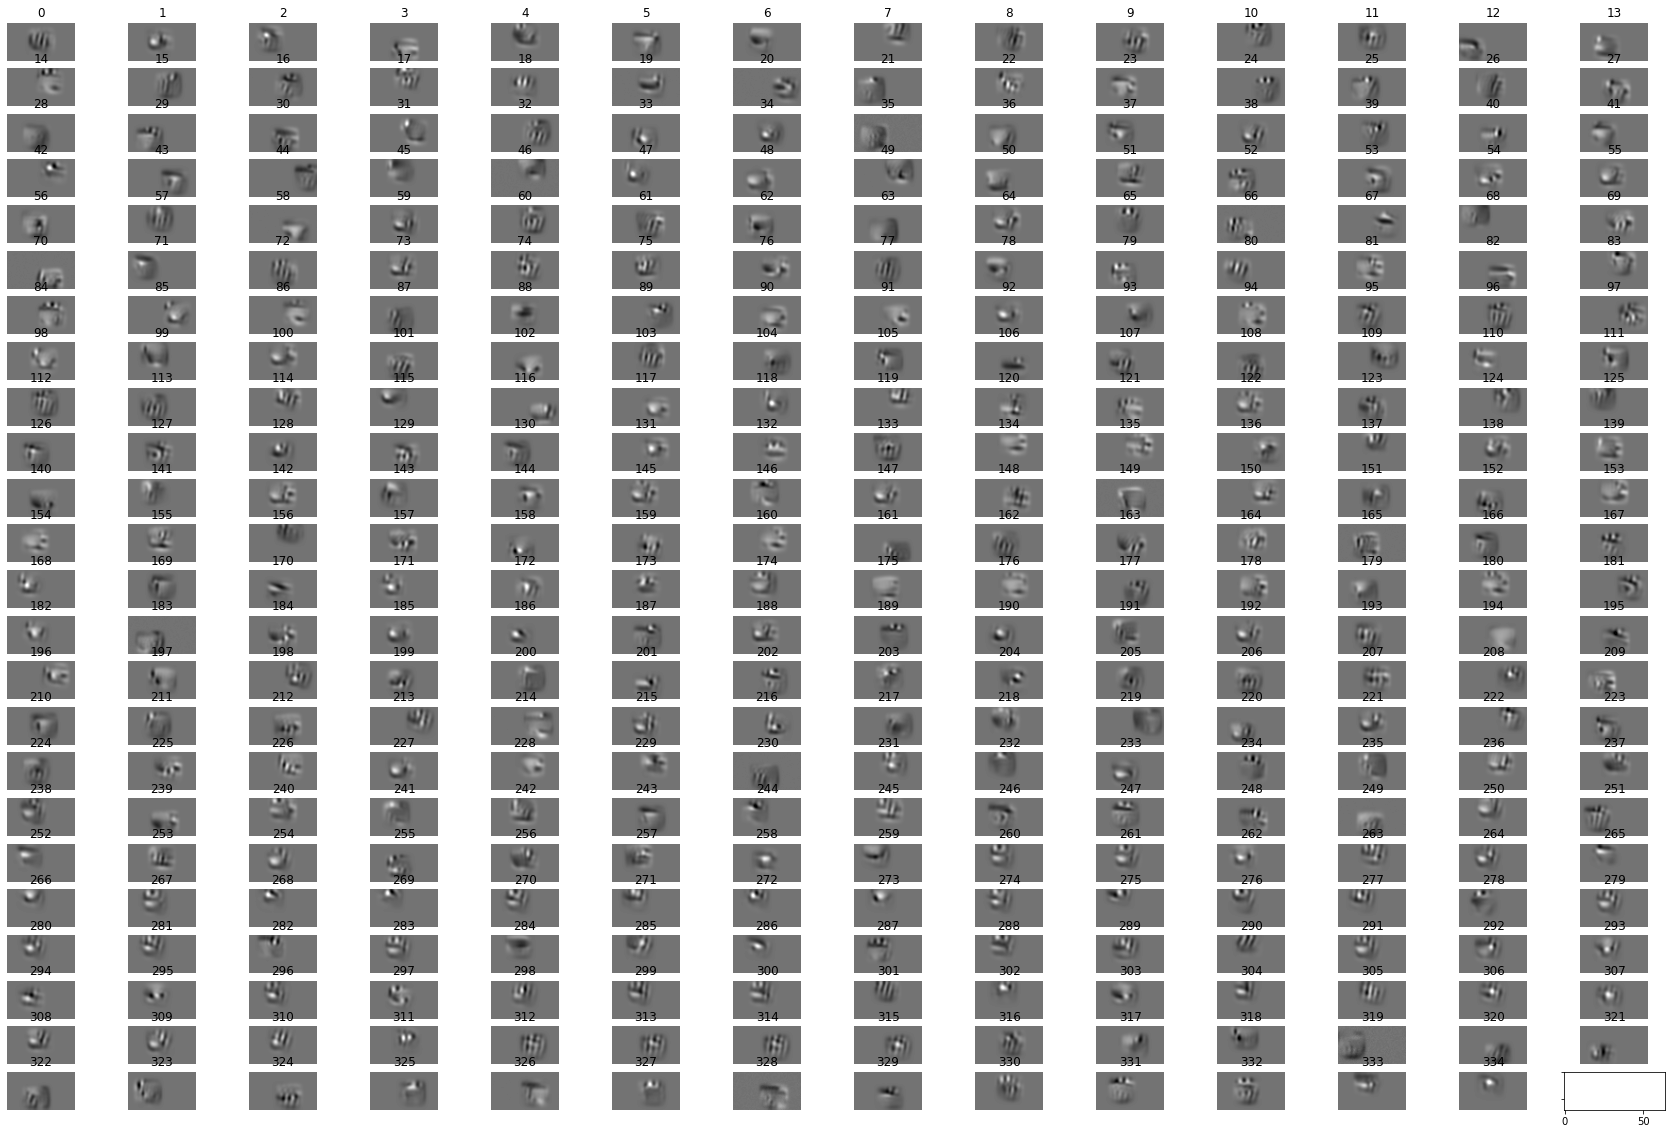

In [46]:
units, keys, mei_path = (MEI() & 'data_key = "128-22-1"').fetch("unit_id", "data_key", "mei", order_by=('data_key','unit_id'))

ncol = 14
nrow = round(len(keys)/ncol)


fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(30, 20), gridspec_kw = {'wspace':0.2, 'hspace':0.2}) 
ax = ax.ravel()
i=0
for ipth in range(len(mei_path)):
    mei = torch.load(mei_path[ipth])
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    ax[i].imshow(mei_array, cmap="gray", vmin=-1.8, vmax=2.2)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axis("off") 
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    ax[i].set_title(f'{i}')
    i=i+1

fig.savefig('npx_meis_128_22.pdf')
#fig.tight_layout()

In [63]:
ls

0f57d6e396d93ff61db225fd89f6bcf5.pth.tar
693213faf1f30427607c966206ac4b31.pth.tar
docker-compose.yml
Dockerfile
env-example
figures/
gifmaker_cache/
mei_AAenKJRODYsgnkoCBIqMehpqHrUPtTQQ.pth_0000.tar
mei_AAenKJRODYsgnkoCBIqMehpqHrUPtTQQ.pth_0001.tar
mei_AAenKJRODYsgnkoCBIqMehpqHrUPtTQQ.pth.tar
mei_aAPufbzzYLLsNBKUQrjILMtFeCTrxRKF.pth_0000.tar
mei_aAPufbzzYLLsNBKUQrjILMtFeCTrxRKF.pth.tar
mei_AaWihZQgKnTDjshhUHeCvRwzgmSadprt.pth_0000.tar
mei_AaWihZQgKnTDjshhUHeCvRwzgmSadprt.pth_0001.tar
mei_AaWihZQgKnTDjshhUHeCvRwzgmSadprt.pth_0002.tar
mei_AaWihZQgKnTDjshhUHeCvRwzgmSadprt.pth.tar
mei_acIQHGvZZFgUIqfknPfWKgjENTvGFVsE.pth_0000.tar
mei_acIQHGvZZFgUIqfknPfWKgjENTvGFVsE.pth.tar
mei_AhMwZclQojZnhXsAWNeOZEAXGhZrRuLp.pth_0000.tar
mei_AhMwZclQojZnhXsAWNeOZEAXGhZrRuLp.pth_0001.tar
mei_AhMwZclQojZnhXsAWNeOZEAXGhZrRuLp.pth.tar
mei_ahyjsBfxSkUzcjdcKiZyDGehumIjYUyB.pth_0000.tar
mei_ahyjsBfxSkUzcjdcKiZyDGehumIjYUyB.pth.tar
mei_aIaaeHDrrOFtIWIiskpYVHNCepIXpRQz.pth_0000.tar
mei_aIaaeHDrrOFtIWIiskpYVHNCepI

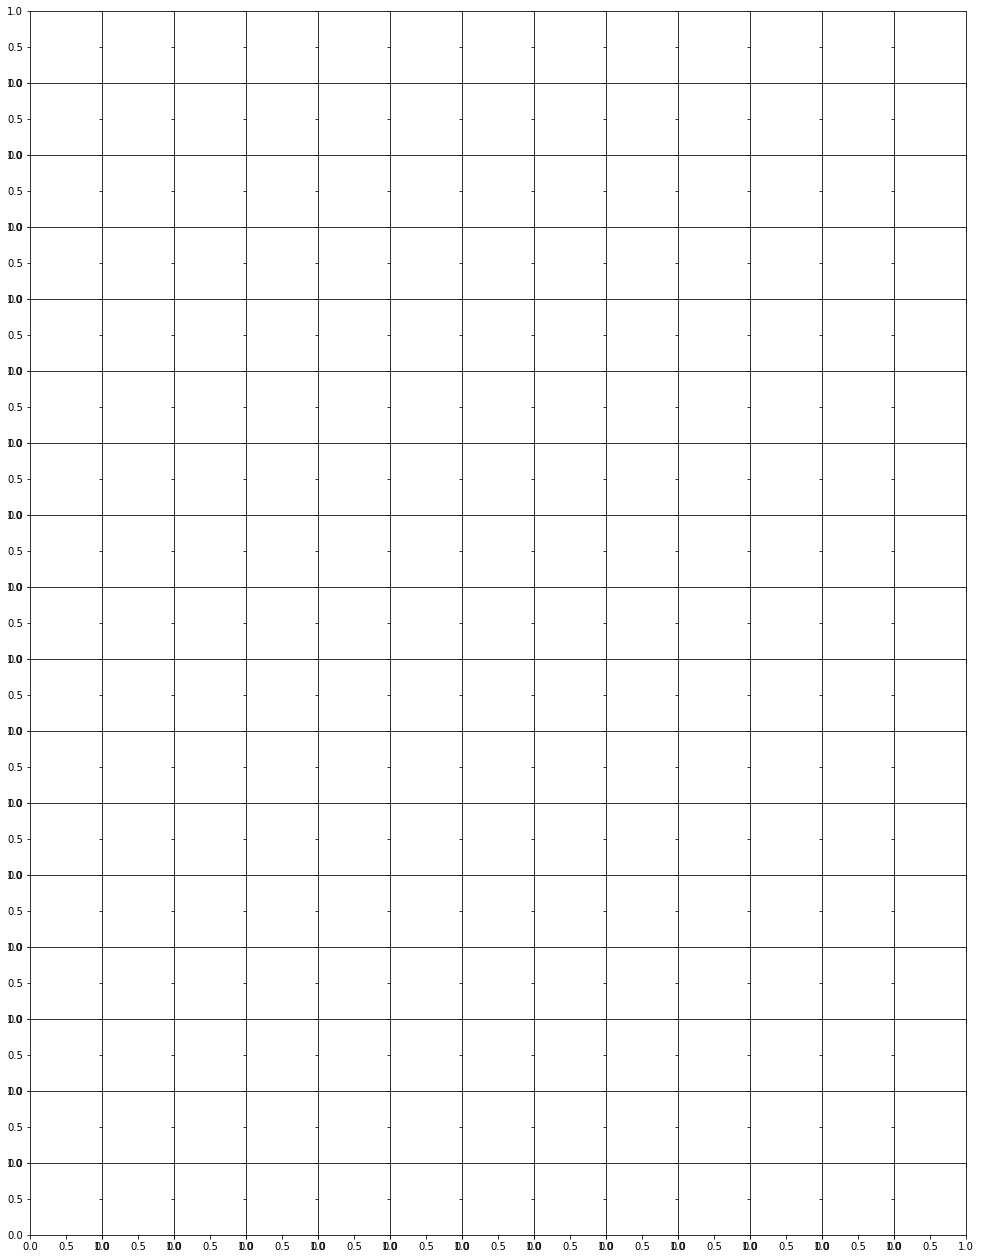

In [182]:
units, keys, mei_path = (MEI() & 'data_key = "27152-28-1" OR data_key = "27152-31-1"').fetch("unit_id", "data_key", "mei", order_by=('data_key','unit_id'))

ncol = 13
nrow = round(len(keys)/ncol)

fig, axes = plt.subplots(
    nrow, ncol,
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                     left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
    figsize=(ncol + 1, nrow + 1),
    sharey='row', sharex='col', #  optionally
)
ax = ax.ravel()

i=0
for ipth in range(len(mei_path)):
    mei = torch.load(mei_path[ipth])
    #print(mei)
    mei_array = mei.detach().cpu().numpy().squeeze()
    ax[i].imshow(mei_array, cmap="gray")
    ax[i].axis("off")
    #ax[i].set_title(f'{keys[ipth]}, unit: {units[ipth]}')
    i=i+1

#fig.savefig('npx_meis_28_31.pdf')


In [97]:
nrow = 7
ncol = 7

fig = plt.figure(figsize=(ncol+1, nrow+1)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        im = np.random.rand(28,28)
        ax= plt.subplot(gs[i,j])
        ax.imshow(im)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.show()

0f57d6e396d93ff61db225fd89f6bcf5.pth.tar
693213faf1f30427607c966206ac4b31.pth.tar
docker-compose.yml
Dockerfile
env-example
figures/
mei_AaWihZQgKnTDjshhUHeCvRwzgmSadprt.pth.tar
mei_aIGioqmQuaRERPXvLMIuzyguILNKUBsq.pth_0000.tar
mei_aIGioqmQuaRERPXvLMIuzyguILNKUBsq.pth_0001.tar
mei_aIGioqmQuaRERPXvLMIuzyguILNKUBsq.pth.tar
mei_AJtmuBbSCWFZcZbufdXxcxxZoVzvOXOk.pth.tar
mei_AKbKdITareFWBCzdxLTbILKkPlHYWCjV.pth_0000.tar
mei_AKbKdITareFWBCzdxLTbILKkPlHYWCjV.pth_0001.tar
mei_AKbKdITareFWBCzdxLTbILKkPlHYWCjV.pth_0002.tar
mei_AKbKdITareFWBCzdxLTbILKkPlHYWCjV.pth.tar
mei_AmdfnKJJHfHxWsVfpzQJeFLukRXrHENl.pth.tar
mei_aoovwCOVdFviTVBMjGqZvZsnOJQpaajz.pth_0000.tar
mei_aoovwCOVdFviTVBMjGqZvZsnOJQpaajz.pth_0001.tar
mei_aoovwCOVdFviTVBMjGqZvZsnOJQpaajz.pth.tar
mei_AQxNDPcJmOceRvSmkSSrQRkCsdHHjpza.pth.tar
mei_aXjhKcBzeYOCyCWQrxGRoQfQwWWcCfkn.pth_0000.tar
mei_aXjhKcBzeYOCyCWQrxGRoQfQwWWcCfkn.pth_0001.tar
mei_aXjhKcBzeYOCyCWQrxGRoQfQwWWcCfkn.pth_0002.tar
mei_aXjhKcBzeYOCyCWQrxGRoQfQwWWcCfkn.pth.tar
mei_AYF